<a href="https://colab.research.google.com/github/Tsung-Hung/dummy-git/blob/master/homw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from functools import reduce
import tensorflow as tf
import scipy.stats as st
import numpy as np
import sys
import os
from PIL import Image
import imageio

In [79]:
enhanced = Image.open('/content/23790_20230221_microisp')
enhanced = np.float32(np.reshape(enhanced, [1, 256, 256, 3])) / 255

dslr = Image.open('/content/23790_GT')
dslr = np.float32(np.reshape(dslr, [1, 256, 256, 3])) / 255

In [80]:
def gauss_kernel(kernlen=21, nsig=3, channels=1):
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    out_filter = np.array(kernel, dtype = np.float32)
    out_filter = out_filter.reshape((kernlen, kernlen, 1, 1))
    out_filter = np.repeat(out_filter, channels, axis = 2)
    return out_filter

def blur(x):
    kernel_var = gauss_kernel(21, 3, 3)
    return tf.nn.depthwise_conv2d(x, kernel_var, [1, 1, 1, 1], padding='SAME')


dslr_yuv = tf.image.rgb_to_yuv(dslr)
enhanced_lab = tf.image.rgb_to_yuv(enhanced)
dslr_yuv
enhanced_uv_blur = blur(enhanced_lab)[..., -2:]
#dslr_uv_blur = blur(dslr_yuv)[..., -2:]
dslr_uv_blur = blur(dslr_yuv)
dslr_uv_blur
# loss_uv = tf.reduce_mean(tf.abs(tf.math.subtract(dslr_uv_blur, enhanced_uv_blur)))
# loss_uv

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[ 0.17184651, -0.00919555, -0.00530345],
         [ 0.20458925, -0.01006913, -0.00615015],
         [ 0.23777431, -0.0106058 , -0.00695727],
         ...,
         [ 0.24511519, -0.02129313,  0.00181106],
         [ 0.21214099, -0.01973405,  0.00157638],
         [ 0.17887816, -0.01776432,  0.00136363]],

        [[ 0.19953388, -0.01013233, -0.00614098],
         [ 0.23744582, -0.01108492, -0.00713022],
         [ 0.27581394, -0.01166685, -0.00807638],
         ...,
         [ 0.28250062, -0.02566447,  0.0028722 ],
         [ 0.24480395, -0.02369933,  0.00251505],
         [ 0.20667799, -0.02126014,  0.00217223]],

        [[ 0.22674042, -0.01070808, -0.00695703],
         [ 0.26960975, -0.01169489, -0.00808748],
         [ 0.3128995 , -0.01228829, -0.00917137],
         ...,
         [ 0.3170377 , -0.03015107,  0.00415128],
         [ 0.2750898 , -0.02774051,  0.00364586],
         [ 0.23255149, -0.0247982 ,  0.0031444

# Pytorch

In [36]:
def rgb_yuv(RGB):
    Y= 0.2990*RGB[:,0,:,:] + 0.5870*RGB[:,1,:,:] + 0.1140*RGB[:,2,:,:]
    Y1=Y
    Y=Y.reshape(Y.shape[0],1,Y.shape[1],Y.shape[2])
    U= (RGB[:,2,:,:]-Y1)/1.772
    U=U.reshape(U.shape[0],1,U.shape[1],U.shape[2])
    V= 0.5*RGB[:,0,:,:] - 0.419*RGB[:,1,:,:] - 0.081*RGB[:,2,:,:]
    V=V.reshape(V.shape[0],1,V.shape[1],V.shape[2])
    YUV= torch.cat([Y,U,V],1)
    return YUV

In [49]:
import numpy as np
import scipy.stats as st
from PIL import Image
import torch
import torch.nn.functional as F

def gauss_kernel(kernlen=21, nsig=3, channels=1):
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    out_filter = np.array(kernel, dtype = np.float32)
    out_filter = out_filter.reshape((kernlen, kernlen, 1, 1))
    out_filter = np.repeat(out_filter, channels, axis = 2)
    return out_filter

# def blur(x):
#     kernel_var = gauss_kernel(21, 3, 1)
#     kernel_var = torch.from_numpy(kernel_var)
#     x = torch.from_numpy(x)
#     x = x.permute(0, 3, 1, 2)
#     x = F.conv2d(x, kernel_var, padding=10, groups=3)
#     x = x.permute(0, 2, 3, 1)
#     return x.numpy()


def blur(x):
    kernel_var = gauss_kernel(21, 3, 3)
    kernel_var = torch.from_numpy(kernel_var)
    x = torch.from_numpy(x)
    x = x.permute(0, 3, 1, 2)
    x = F.conv2d(x, kernel_var, padding=10, groups=3)
    x = x.permute(0, 2, 3, 1)
    return x.numpy()

# enhanced_uv_blur = blur(enhanced_lab.numpy())[..., 1:]
# dslr_uv_blur = blur(dslr_yuv.numpy())[..., 1:]
# loss_uv = torch.mean(torch.abs(dslr_uv_blur - enhanced_uv_blur))
# loss_uv

In [73]:
import torchvision.transforms as transforms

def blur(x):
    blur_transform = transforms.GaussianBlur(kernel_size=21, sigma=3)
    return blur_transform(x)

In [81]:
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

def blur(x):
    blur_transform = transforms.GaussianBlur(kernel_size=21, sigma=3)
    return blur_transform(x)

enhanced = Image.open('/content/23790_20230221_microisp').convert('RGB')
enhanced = TF.to_tensor(enhanced)

dslr = Image.open('/content/23790_GT').convert('RGB')
dslr = TF.to_tensor(dslr)

dslr = dslr.reshape(1,3,256,256)
dslr_yuv = rgb_yuv(dslr)

enhanced_lab = enhanced.reshape(1,3,256,256)
enhanced_lab = rgb_yuv(enhanced_lab)

dslr_yuv_blur = blur(dslr_yuv)
enhanced_lab = blur(enhanced_lab)
loss_uv = torch.mean(torch.abs(dslr_yuv_blur - enhanced_lab))
loss_uv

tensor(0.0272)

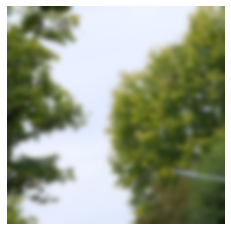

In [83]:
import matplotlib.pyplot as plt
from matplotlib import colors
from skimage import color

# Convert the tensor to a NumPy array and transpose the axes
dslr_yuv_blur_np = dslr_yuv_blur.cpu().numpy().squeeze().transpose(1, 2, 0)

# Convert the YUV image to RGB
dslr_yuv_blur_rgb = color.yuv2rgb(dslr_yuv_blur_np)

# Plot the RGB image
plt.imshow(dslr_yuv_blur_rgb)
plt.axis('off')
plt.show()